In [ ]:
!pip install keras

In [ ]:
!pip install keras_cv

In [ ]:
!pip install matplotlib

In [ ]:
!cp -r '/content/drive/MyDrive/Colab Notebooks/chest_xray' data

In [ ]:
!ls data

test  train


In [ ]:
"""
Modified code from: "[KerasCV] Image classification from scratch" under the Apache 2.0 License.
Link: https://github.com/keras-team/keras-io/blob/master/examples/vision/image_classification_from_scratch.py
Dataset directory must be changed. We uploaded the dataset to Google Drive for easier use with Colab. The base
directory of the dataset should be updated accordingly.
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_cv



import os

num_skipped = 0
for folder_name in ("NORMAL", "PNEUMONIA"):
    folder_path = os.path.join("/content/data/train", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)


"""
## Generate a `Dataset`
"""

image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/data/train",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 5053 files belonging to 2 classes.
Using 4043 files for training.
Using 1010 files for validation.


In [ ]:

data_augmentation = keras.Sequential(
    [
        keras_cv.layers.RandomFlip(),
        keras_cv.layers.RandAugment(
            value_range=(0, 255),
            augmentations_per_image=2,
            magnitude=0.5,
            magnitude_stddev=0.15,
        ),
    ]
)


In [ ]:

# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

"""
## Build a model

"""


def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

"""
## Train the model
"""

epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 1/25
32/32 [==============================] - 85s 2s/step - loss: 0.5336 - accuracy: 0.7457 - val_loss: 0.6060 - val_accuracy: 0.7436
Epoch 2/25
32/32 [==============================] - 51s 1s/step - loss: 0.3639 - accuracy: 0.8333 - val_loss: 0.5691 - val_accuracy: 0.7436
Epoch 3/25
32/32 [==============================] - 52s 2s/step - loss: 0.3109 - accuracy: 0.8714 - val_loss: 0.5822 - val_accuracy: 0.7436
Epoch 4/25
32/32 [==============================] - 51s 2s/step - loss: 0.2623 - accuracy: 0.8959 - val_loss: 0.6036 - val_accuracy: 0.7436
Epoch 5/25
32/32 [==============================] - 52s 2s/step - loss: 0.2251 - accuracy: 0.9072 - val_loss: 0.6648 - val_accuracy: 0.7436
Epoch 6/25
32/32 [==============================] - 52s 2s/step - loss: 0.2190 - accuracy: 0.9095 - val_loss: 0.7133 - val_accuracy: 0.7436
Epoch 7/25
32/32 [==============================] - 52s 2s/step - loss: 0.1909 - accuracy: 0.9233 - val_loss: 0.8213 - val_accuracy: 0.7436
Epoch 8/25
32/32 [==

1/1 [==============================] - 1s 565ms/step
This image is 95.43% Normal and 4.57% pneumonia.


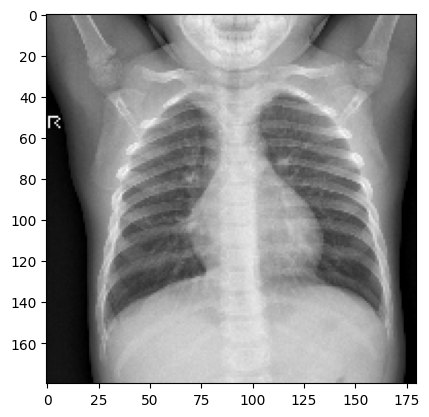

In [ ]:
import matplotlib.pyplot as plt

img = keras.utils.load_img("/content/data/test/NORMAL/IM-0103-0001.jpeg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% Normal and {100 * score:.2f}% pneumonia.")

In [ ]:
model.save('trained_model.keras')

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/data/test",
    image_size=image_size,
    batch_size=batch_size,
)

predictions = model.predict(test_ds)


Found 624 files belonging to 2 classes.
5/5 [==============================] - 8s 2s/step


In [ ]:
import numpy
from sklearn.metrics import classification_report

class_names = ["Normal", "Pneumonia"]

# Convert probabilities to class labels
predicted_labels = [class_names[int(numpy.around(pred))] for pred in predictions]

# Get true labels from the dataset
true_labels = [class_names[label] for _, labels in test_ds for label in labels.numpy()]

# Display classification report
print(classification_report(true_labels, predicted_labels, target_names=class_names))

              precision    recall  f1-score   support

      Normal       0.40      0.04      0.08       234
   Pneumonia       0.63      0.96      0.76       390

    accuracy                           0.62       624
   macro avg       0.51      0.50      0.42       624
weighted avg       0.54      0.62      0.50       624



In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming you have two classes (cat and dog)
class_names = ["Normal", "Pneumonia"]

# Define your custom threshold
threshold = 0.95  # Adjust this threshold as needed

# Convert probabilities to class labels using the custom threshold
predicted_labels = [class_names[int(pred > threshold)] for pred in predictions]

# Get true labels from the dataset
true_labels = [class_names[label] for _, labels in test_ds for label in labels.numpy()]

# Display classification report
print(classification_report(true_labels, predicted_labels, target_names=class_names))

              precision    recall  f1-score   support

      Normal       0.44      0.12      0.19       234
   Pneumonia       0.63      0.91      0.75       390

    accuracy                           0.61       624
   macro avg       0.54      0.51      0.47       624
weighted avg       0.56      0.61      0.54       624

